# Assignments by Felix Vernieuwe

---
---

## Assignment 2: Feature Engineering
---
---

In [10]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from lightgbm.sklearn import LGBMRanker

from FelixVernieuwe.util import setup_seaborn, hex_id_to_int

setup_seaborn()

In [11]:
# Load in the datasets
articles = pd.read_parquet("../../data/alt/articles.parquet")
customers = pd.read_parquet("../../data/alt/customers.parquet")
transactions = pd.read_parquet("../../data/alt/transactions_train.parquet")

In [12]:
reference_week = transactions["week"].max() + 1

used_features = [
    'article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
    'perceived_colour_master_id', 'department_no', 'index_code',
    'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
    'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 
    
    'has_promotion', 'bestseller_rank', 'all_time_rank', 'price_sensitivity'
]

---
## Feature Engineering
---

### Product features

#### Bestsellers of last week

In [13]:
# Get the highest selling articles of the last week
bestsellers = transactions[transactions["week"] == reference_week - 1]["article_id"].value_counts().head(200).index.tolist()

#### Discounted products

In [14]:
# Adds 'has_promotion' feature to the dataset and gets all the promoted articles
from features import *

transactions, customers, articles, promoted_articles = discount_feature(transactions, customers, articles)

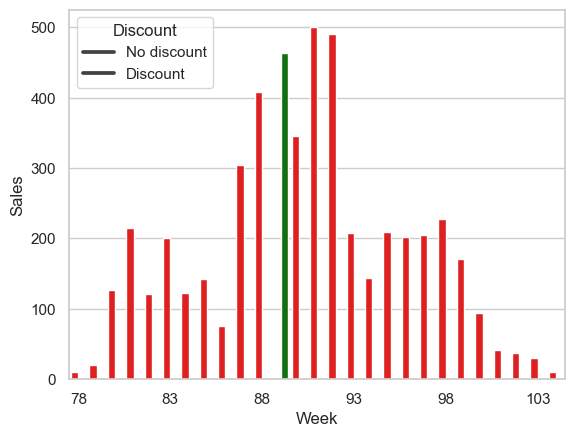

In [15]:
plot_random_product_sales(transactions, promoted_articles)

#### All time rank

In [16]:
transactions, customers, articles = all_time_rank_feature(transactions, customers, articles)

### Customer features

#### Price sensitivity

In [17]:
transactions, customers, articles = price_sensitivity_feature(transactions, customers, articles)

### General features

#### Bestseller Ranking

In [18]:
# Adds 'bestseller_rank' feature to the dataset
transactions, customers, articles = bestseller_rank_feature(transactions, customers, articles, reference_week)

C:\Users\Felix\PycharmProjects\ai-project-23-24\FelixVernieuwe\02 - Feature Engineering\bestseller_rank_feature.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['bought'] = 1


---
## Training preparation
---

In [19]:
# Merge transactions data with article and customer information
data = transactions.copy()
data = data.merge(articles, on="article_id", how="left")
data = data.merge(customers, on="customer_id", how="left")

# Clean up incoming data
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

if "bought" not in data:
    data["bought"] = 1

In [20]:
# Split up training and test datasets
is_reference = data["week"] == reference_week
train = data[~is_reference]
test = data[is_reference]

# Ensure that each article appears only once per customer
test = test.drop_duplicates(["customer_id", "article_id", "sales_channel_id"]).copy()

# Gives amount of items purchased per customer per week (used for training the ranking)
train_bins = train.groupby(["week", "customer_id"])["article_id"].count().values

In [21]:
# Train only on specified features 
available_features = [feature for feature in used_features if feature in train.columns]

train_X = train[available_features]
train_y = train["bought"]

test_X = test[available_features]

---
## Model Training
---

In [22]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

ranker = ranker.fit(
    train_X,
    train_y,
    group=train_bins,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.804135
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.171531
[LightGBM] [Debug] init for col-wise cost 0.183345 seconds, init for row-wise cost 0.274822 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.277386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1343
[LightGBM] [Info] Number of data points in the train set: 11381612, number of used features: 21
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12


C:\Users\Felix\AppData\Local\Temp\ipykernel_8704\282366598.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(["{:.1f}%".format(x) for x in plot.get_xticks()])


[Text(0.001, 0, '0.0%'),
 Text(0.01, 0, '0.0%'),
 Text(0.1, 0, '0.1%'),
 Text(1.0, 0, '1.0%'),
 Text(10.0, 0, '10.0%'),
 Text(100.0, 0, '100.0%'),
 Text(1000.0, 0, '1000.0%'),
 Text(10000.0, 0, '10000.0%')]

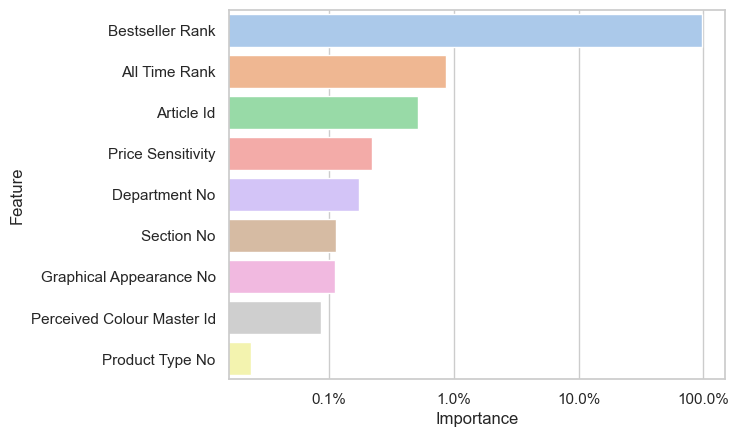

In [42]:
# Percentual importance of each feature
feature_importance = pd.DataFrame(
    {
        "feature": available_features,
        "importance": ranker.feature_importances_,
    }
).sort_values("importance", ascending=False)

feature_importance["importance"] = feature_importance["importance"] / feature_importance["importance"].sum() * 100
feature_importance["feature"] = feature_importance["feature"].map(lambda x: x.replace("_", " ").title())

feature_importance = feature_importance[feature_importance["importance"] > 0]

plot = sns.barplot(x="importance", y="feature", data=feature_importance)
plot.set_xlabel("Importance")
plot.set_ylabel("Feature")

plot.set_xscale("log")
plot.set_xticklabels(["{:.1f}%".format(x) for x in plot.get_xticks()])

In [40]:
feature_importance

,feature,importance
18,Bestseller Rank,97.875903
19,All Time Rank,0.867665
0,Article Id,0.522510
20,Price Sensitivity,0.220383
6,Department No,0.174640
9,Section No,0.114107
2,Graphical Appearance No,0.113247
5,Perceived Colour Master Id,0.087463
1,Product Type No,0.024081
4,Perceived Colour Value Id,0.000000


---
## Predictions
---

In [24]:
# Predict on test set
test["pred"] = ranker.predict(test_X)

# Per user, predict up to 12 articles
predicted_articles = test \
    .sort_values(["customer_id", "pred"], ascending=False) \
    .groupby("customer_id")["article_id"].apply(list).to_dict()

In [25]:
interesting_products = []
if promoted_articles is not None:
    current_promos = promoted_articles[promoted_articles["week"] == reference_week - 1]
    bestsellers_df = pd.DataFrame({"article_id": bestsellers})
    interesting_products = bestsellers_df.merge(current_promos, on="article_id", how="inner")
    interesting_products = interesting_products[interesting_products["has_promotion"] == True]["article_id"].tolist()
bestsellers = bestsellers[:20]

In [26]:
# Fill up the list of customers with the top sellers randomly
# TODO: figure out a separate classifier for determining best seller?

def determine_predictions(customer_id):
    articles = predicted_articles.get(customer_id, [])
    if len(articles) < 12:
        articles = articles + interesting_products
        if len(articles) < 12:
            # articles = articles + np.random.choice(bestsellers, 12 - len(articles), replace=False).tolist()
            articles = articles + bestsellers
    articles = articles[:12]
    return " ".join(["0" + str(article) for article in articles])

---
## Submission
---

In [27]:
# Read in sample submission (customer_id, prediction)
submission = pd.read_csv("../../data/submissions/sample_submission.csv")

# Replace predictions with predictions from model (get via dict
submission["prediction"] = submission["customer_id"].map(lambda x: determine_predictions(hex_id_to_int(x)))

In [28]:
# Write submission to zipped csv
filename = "engineered_0_submission"

submission.to_csv(f"../../data/submissions/{filename}.csv.gz", index=False)